In [1]:
#Setup without google drive access
data_folder = 'data'
!git clone https://github.com/mogwai/fastai_audio.git
%cd fastai_audio
!git pull
!bash install.sh

Cloning into 'fastai_audio'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 1500 (delta 33), reused 136 (delta 23), pack-reused 1342
Receiving objects: 100% (1500/1500), 177.10 MiB | 12.34 MiB/s, done.
Resolving deltas: 100% (853/853), done.
/content/fastai_audio
Already up to date.
     |████████████████████████████████| 81kB 4.3MB/s 
  Created wheel for fire: filename=fire-0.2.1-py2.py3-none-any.whl size=103527 sha256=ba8895c9e21c9792ad02edbcf4b14edc7b4ebcfdbd3398dbf2a6bc019c626425
  Stored in directory: /root/.cache/pip/wheels/31/9c/c0/07b6dc7faf1844bb4688f46b569efe6cafaa2179c95db821da
Successfully built fire
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following additional packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libmagic-mgc libm

In [0]:
from IPython.core.debugger import set_trace
import sys , os
from audio import *
np.random.seed(2)

In [3]:
!wget https://public-datasets.fra1.digitaloceanspaces.com/250-speakers.tar

--2019-11-12 15:10:28--  https://public-datasets.fra1.digitaloceanspaces.com/250-speakers.tar
Resolving public-datasets.fra1.digitaloceanspaces.com (public-datasets.fra1.digitaloceanspaces.com)... 5.101.109.41
Connecting to public-datasets.fra1.digitaloceanspaces.com (public-datasets.fra1.digitaloceanspaces.com)|5.101.109.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9220510576 (8.6G) [application/gzip]
Saving to: ‘250-speakers.tar’

250-speakers.tar    100%[===================>]   8.59G  11.4MB/s    in 13m 32s 

2019-11-12 15:24:01 (10.8 MB/s) - ‘250-speakers.tar’ saved [9220510576/9220510576]



In [4]:
!tar -xvf 250-speakers.tar

Output hidden; open in https://colab.research.google.com to view.

In [0]:
from  audio import *
sg_cfg= SpectrogramConfig(hop=128, n_mels=128, n_fft=1024, top_db=80, f_min=20, f_max=22050)
config_segment = AudioConfig(cache=True,remove_silence = "trim", sg_cfg=sg_cfg ,segment_size=7000, delta=True,mfcc=True,downmix=True)
tfms = get_spectro_transforms(size=(128,432),mask_time=True, mask_frequency=True,roll=True,num_rows=40, num_cols=28)#using 224 for resnet50 use 256 for resnet34

In [0]:
def answer(path):
  d = str(path)[len('250-speakers/'):len('250-speakers/id09210')]
  return d

In [8]:
db_sg = (AudioList.from_folder('250-speakers', config=config_segment).
         split_by_rand_pct(0.2, seed=29).
         label_from_func(answer).
         transform(tfms=tfms).
         databunch(bs=256))

Preprocessing: Downmixing to Mono


Preprocessing: Removing Silence


Preprocessing: Segmenting Items


Preprocessing: Downmixing to Mono


Preprocessing: Removing Silence


Preprocessing: Segmenting Items


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


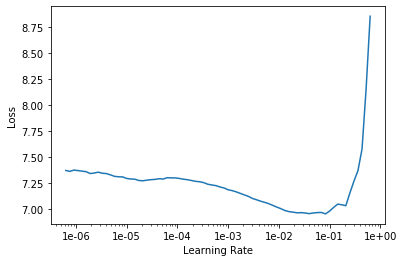

In [9]:
from fastai.callbacks import *
learn = audio_learner(db_sg, models.resnet34,callback_fns=[ShowGraph], metrics=[accuracy]).mixup()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,5.961386,5.306512,0.045444,17:12
1,5.229531,7.020136,0.077331,09:33
2,4.743623,3.615539,0.219268,09:32
3,4.468528,3.819040,0.160570,09:33
4,3.861617,2.537954,0.410361,09:32
5,3.579945,2.200544,0.480648,09:33
6,3.400751,1.963686,0.537832,09:35
7,3.265973,1.899635,0.553056,09:34
8,3.153019,1.825328,0.563130,09:34
9,3.022995,1.625814,0.611679,09:34


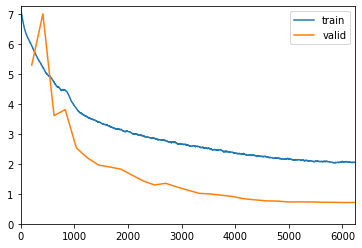

In [10]:
from fastai.callbacks import *
lr = 1e-2
learn.fit_one_cycle(30, slice(lr/100,lr),wd=1e-3)

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(200,200))